In [22]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tslearn.metrics import dtw
from umap import UMAP
from tqdm import tqdm

from infodynamics import WindowedRollingDistance
from infodynamics.util import calc_vector_histogram

from src.dataset.util import read_jsonl, write_jsonl

In [3]:
def generate_xticks(df):
    # flag indices, where the next element is different
    yr_switches = np.diff(df["year"])
    # add last element
    yr_switches = np.append(0, yr_switches)
    # convert to bool
    yr_switches = np.array(yr_switches, dtype=bool)

    # get index (x-axis) and year variables (x-axis label)
    sig_index = np.array(df.index)
    sig_year = np.array(df["year"])

    # mark changes in year
    xticks_idx = sig_index[yr_switches]
    xticks_label = sig_year[yr_switches]

    return xticks_idx, xticks_label

# data
select only article bodies with embeddings for further analysis

In [4]:
INTERIM_PATH = '../data/interim/'
PROCESSED_PATH = '../data/processed/'

embs = read_jsonl(os.path.join(PROCESSED_PATH, 'publications_merged_concat.ndjson'))
meta = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_months.csv'), sep=';')

In [5]:
# split into publication id & section
embs_df = pd.DataFrame(embs).drop(columns=['pub_date'])
embs_df[['pub_id', 'section']] = embs_df['id'].str.split('_', expand=True) 
embs_df.head()

,id,text,embeddings,warning,pub_id,section
0,p1_a,,[],empty,p1,a
1,p1_b,\nfor other things and stumbled across psychol...,"[-0.010761050507426262, 0.02184978313744068, 0...",ok :),p1,b
2,p2_a,"This article may be used for research, teachin...","[-0.009430318139493465, 0.0022036083973944187,...",ok :),p2,a
3,p2_b,"\nIn their classic work, Heider and Simmel (19...","[-0.030965760350227356, 0.0006598980980925262,...",ok :),p2,b
4,p3_a,,[],empty,p3,a


In [8]:
# reconstruct yyyy-mm-dd date
dates = []
for i, row in meta.iterrows():
    year_month = f"{int(row['year'])}-{int(row['month'])}-01"
    pub_date = pd.to_datetime(year_month, format='%Y-%m-%d')
    dates.append(pub_date)

meta['date'] = dates
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   pub_id  272 non-null    object        
 1   path    272 non-null    object        
 2   doi     142 non-null    object        
 3   source  272 non-null    object        
 4   year    272 non-null    float64       
 5   month   272 non-null    int64         
 6   date    272 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 15.0+ KB


In [9]:
# merge embeddings with metadata
df = embs_df.merge(meta[['pub_id', 'year', 'source', 'date']], on='pub_id', how='left')
# sort by date!
df = df.sort_values('date')
df.head()

,id,text,embeddings,warning,pub_id,section,year,source,date
376,p189_a,An experiment was designed to investigate the ...,"[-0.012126105837523937, 0.017757242545485497, ...",ok :),p189,a,1969.0,parsing,1969-01-01
377,p189_b,INTRODUCTION\nOne of the most important featur...,"[-0.01675822027027607, 0.025037338957190514, 0...",ok :),p189,b,1969.0,parsing,1969-01-01
379,p190_b,"\n(1965,\n1966)\n \nhave demonstrated the int...","[-0.0327637754380703, 0.02097960375249386, 0.0...",ok :),p190,b,1969.0,parsing,1969-09-01
378,p190_a,,[],empty,p190,a,1969.0,parsing,1969-09-01
372,p187_a,"Normal, autistic, and subnormal children repro...","[-0.030722646042704582, 0.015215655788779259, ...",ok :),p187,a,1970.0,parsing,1970-01-01


### checking missing data

In [28]:
df.query('warning == "empty"').groupby('section').size()

section
a    78
dtype: int64

In [10]:
df['warning'] = df['warning'].str.slice(0, 15)
df.groupby('warning').size()

warning
empty     78
ok :)    466
dtype: int64

### analysis subset
no abstracts, full embeddings

In [11]:
# select only full embeddings & article bodies
df_full = (df
               .query('warning == "ok :)"')
               .query('section == "b"')
               )

df_full

,id,text,embeddings,warning,pub_id,section,year,source,date
377,p189_b,INTRODUCTION\nOne of the most important featur...,"[-0.01675822027027607, 0.025037338957190514, 0...",ok :),p189,b,1969.0,parsing,1969-01-01
379,p190_b,"\n(1965,\n1966)\n \nhave demonstrated the int...","[-0.0327637754380703, 0.02097960375249386, 0.0...",ok :),p190,b,1969.0,parsing,1969-09-01
373,p187_b,\nIt has recently been suggested that the unde...,"[-0.030136963352560997, 0.03472242131829262, 0...",ok :),p187,b,1970.0,parsing,1970-01-01
371,p186_b,\nI t could be hypothesized that there are two...,"[-0.03267296031117439, 0.018821272999048233, 0...",ok :),p186,b,1970.0,parsing,1970-06-01
375,p188_b,\nThe hypothesis of a deficit in central proce...,"[-0.034630823880434036, 0.028664667159318924, ...",ok :),p188,b,1970.0,parsing,1970-08-01
...,...,...,...,...,...,...,...,...,...
151,p76_b,\nUta Frith began her science career studying ...,"[-0.021618565544486046, 0.0042715719901025295,...",ok :),p76,b,2020.0,parsing,2020-07-01
131,p66_b,"\nGoldman, 2006;\nGopnik, 1993)\n. Autism thu...","[-0.02129972167313099, 0.0030547252390533686, ...",ok :),p66,b,2021.0,parsing,2021-01-01
139,p70_b,Introduction\nTheory of Mind is defined as the...,"[-0.030077671632170677, -0.007493732497096062,...",ok :),p70,b,2021.0,parsing,2021-01-01
149,p75_b,\nWe are grateful for the careful thought that...,"[-0.02133309282362461, 0.02723802998661995, 0....",ok :),p75,b,2021.0,parsing,2021-02-01


### source comparison
check information extraction strategies

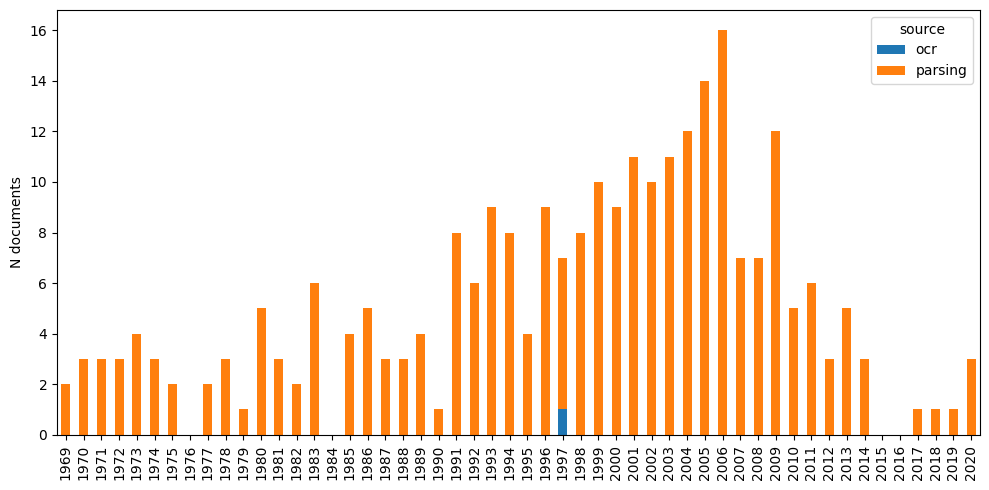

In [12]:
# year: datetime is for counting, year: float is for visualization
df_full['year_'] = pd.to_datetime(df_full['year'], format='%Y')
# generate all years between first and last publication (incl)
all_years_in_range = pd.date_range(start=df_full['year_'].min(), end=df_full['year_'].max(), freq='Y').year

# inject our publication dataset with all years (add years without publications)
proportions = df_full.groupby(['year', 'source']).size().unstack(fill_value=0) #.apply(lambda x: x / x.sum(), axis=1)
proportions = proportions.reindex(all_years_in_range, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
proportions.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('N documents')
plt.tight_layout()
plt.savefig('fig/source_breakdown.png', dpi=300)

### sanity check for missing documents

In [13]:
def get_file_paths(folder_path: str) -> tuple[list, list]:
    """
    """

    pdf_paths = []
    other_paths = []
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            filepath = os.path.join(root, filename)
            if filename.endswith('.pdf'):
                pdf_paths.append(filepath)
            else:
                other_paths.append(filepath)

    return pdf_paths, other_paths

pdf_paths, other_paths = get_file_paths('../data/raw/publications_manual_export/UTA publications/')
pdf_paths = [path[3:] for path in pdf_paths]
len(pdf_paths)

272

In [14]:
# how many docs are not overlapping
len(
    set(pdf_paths) - set(meta['path'].unique().tolist())
)

6

We have two types of documents:
- `parsing`: PDFs with extractable text (n=154). Mostly the newer publications that were "born digitally"
- `ocr`: PDFs where we had to conduct optical character recognition ourselves (n=121).

The difference in text quality between these two types of documents is substantial; We address this by using a robust pre-trained model to acquire the representations, but need a couple more checks.  
We successfully parsed 271 PDF files out of 272.  

# 2D plots

In [16]:
X_2d = UMAP(n_components=2, random_state=42, metric='cosine').fit_transform(df_full['embeddings'].tolist())

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


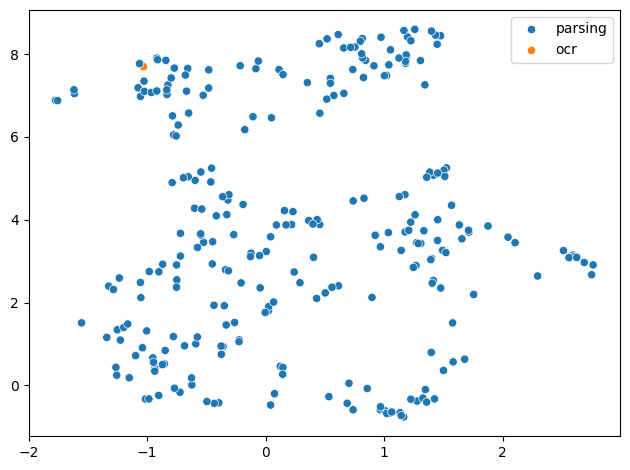

In [18]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full['source'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap_source.png', dpi=300)

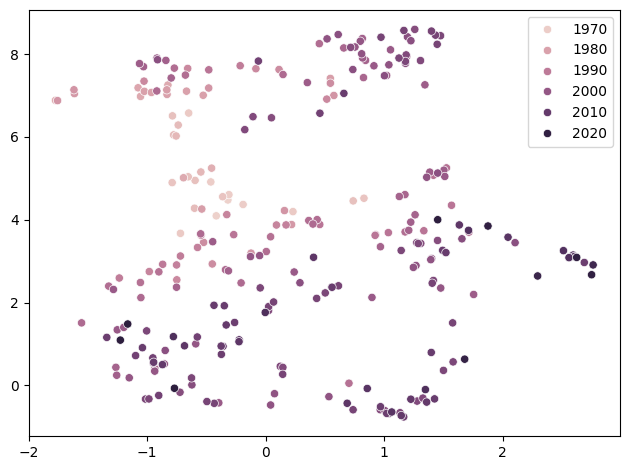

In [19]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full['year'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap_year.png', dpi=300)

# infodynamics


In [20]:
X = df_full['embeddings'].tolist()
X = np.array(X)
X.shape

(272, 1536)

In [21]:
X_prob = [calc_vector_histogram(vect, bins=100) for vect in X]
X_prob = np.array(X_prob)
X_prob.shape

(272, 100)

### window testing
run through a bunch of windows, then calculate dtw between them and pick the one with the lowest avg distance

In [66]:
w_grid = list(range(2, 51))
signals_w = {}

for w in tqdm(w_grid):

    wd_i = WindowedRollingDistance(
        measure='jensenshannon',
        window_size=w,
        estimate_error=True
    )

    signal_i = wd_i.fit_transform(X_prob)
    signals_w.update({w: signal_i})

100%|██████████| 49/49 [00:01<00:00, 30.20it/s]


In [68]:
cut_zeros = False

distance_matrix = []
for index_left in tqdm(w_grid):
    distance_row = []
    nov_left = signals_w[index_left]['N_hat'].reshape(-1, 1)
    if cut_zeros:
        nov_left = nov_left[index_left:]
    for index_right in w_grid:
        nov_right = signals_w[index_right]['N_hat'].reshape(-1, 1)
        if cut_zeros:
            nov_right = nov_right[index_right:]
        dist = dtw(nov_left, nov_right)
        distance_row.append(dist)
    distance_matrix.append(distance_row)

100%|██████████| 49/49 [00:01<00:00, 40.50it/s]


,window,inertia
23,25,0.443316
22,24,0.449936
21,23,0.459741
20,22,0.466989
16,18,0.518728


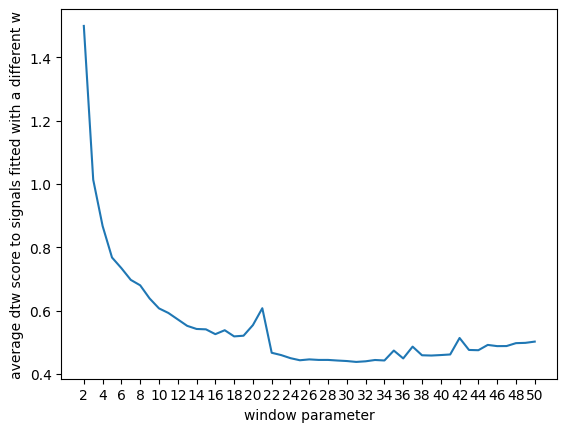

In [80]:
window_intertia = pd.DataFrame({
    'window': list(range(2, 51)),
    'inertia': np.array(distance_matrix).mean(axis=1)
})

plt.plot(
    window_intertia['window'],
    window_intertia['inertia']
)

plt.xticks(range(2, 51, 2))
plt.xlabel('window parameter')
plt.ylabel('average dtw score to signals fitted with a different w')

(window_intertia
    .query('window <= 25')
    .sort_values(by='inertia')
    .head(5)
    )

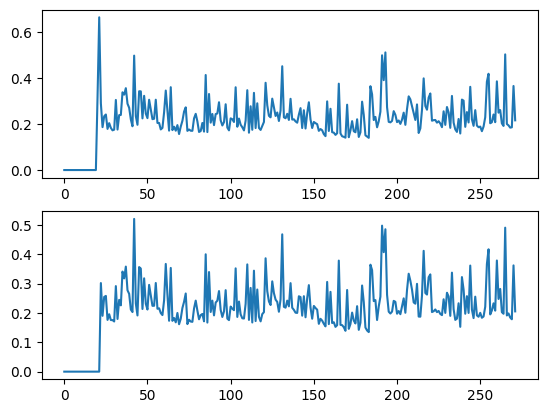

In [70]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(signals_w[20]['N_hat'])
axs[1].plot(signals_w[22]['N_hat'])

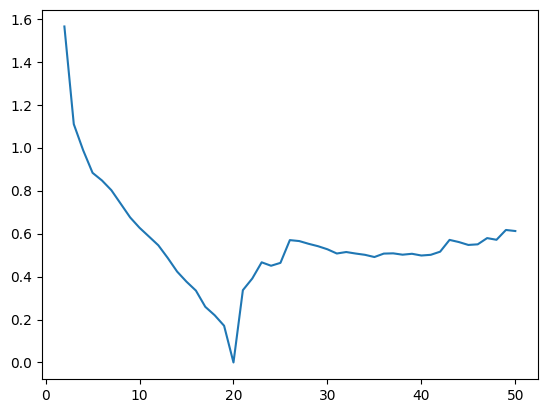

In [74]:
distances_to_main = []
for w in w_grid:
    d_to_main = dtw(signals_w[20]['N_hat'], signals_w[w]['N_hat'])
    distances_to_main.append(d_to_main)

plt.plot(
    w_grid, 
    distances_to_main
)

### window=20

In [78]:
w_main = WindowedRollingDistance(
    measure='jensenshannon',
    window_size=20,
    estimate_error=True
)

signal = w_main.fit_transform(X_prob)

In [79]:
signal_df = pd.DataFrame(signal)
signal_df['pub_id'] = df_full['pub_id'].tolist()
signal_df['date'] = df_full['date'].tolist()
signal_df['year'] = df_full['year'].tolist()
signal_df.to_csv('fig/signal_pub_jsd_w20.csv', index=False)

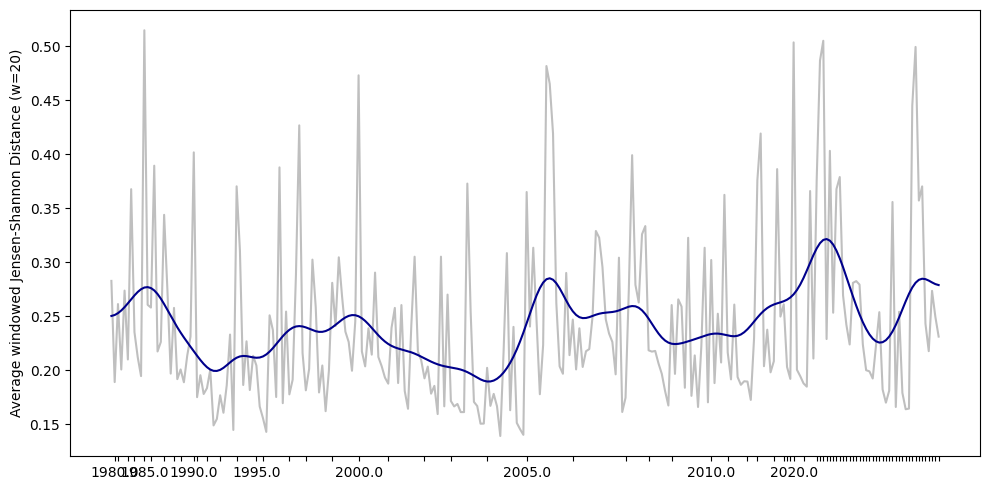

In [60]:
n_df = signal_df.iloc[20:, :]
n_hat = n_df['N_hat'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_hat, c='grey', alpha=0.5)
ax.plot(
    gaussian_filter1d(n_hat, sigma=5), c='darkblue'
)

xticks_idx_n, xticks_label_n = generate_xticks(n_df.reset_index())
modified_ticks = ['' if i % 5 != 0 and i != xticks_label_n[0] else i for i in xticks_label_n]

values_to_hide = [1975]
modified_ticks = ['' if i in values_to_hide else i for i in modified_ticks]

ax.set_xticks(ticks=xticks_idx_n, labels=modified_ticks)
ax.set_ylabel('Average windowed Jensen-Shannon Distance (w=20)')

plt.tight_layout()

### peaks

In [62]:
n_df.query('N_hat > 0.45')

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,pub_id,date,year,source
30,0.514885,0.150568,0.366952,0.124846,0.147933,0.137707,p127,1985-03-01,1985.0,parsing
95,0.473162,0.151439,0.417891,0.129308,0.055271,0.140374,p174,2000-01-01,2000.0,parsing
152,0.481769,0.131235,0.426035,0.178712,0.055734,0.154974,p44,2005-10-01,2005.0,parsing
153,0.465310,0.167887,0.459311,0.151004,0.005999,0.159446,p40,2005-10-01,2005.0,parsing
227,0.503664,0.152637,0.656110,0.128498,-0.152447,0.140567,p67,2020-01-01,2020.0,parsing
235,0.486775,0.179286,0.218751,0.125978,0.268024,0.152632,p115,NaT,NaN,NaN
236,0.505169,0.183598,0.273562,0.140340,0.231607,0.161969,p118,NaT,NaN,NaN
264,0.499472,0.148316,0.000000,0.000000,0.499472,0.074158,p236,NaT,NaN,NaN


In [65]:
peak_ids = n_df.query('N_hat > 0.45')['pub_id'].tolist()

meta.query('pub_id == @peak_ids').sort_values('year')['path'].tolist()

['data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/1985/Frith, The usefulness of the concept of unexpected reading failure.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/2000/Abell, Happe and Frith, Do triangles play tricks.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/SIlani Paulesu VBM.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/Silani Dys Proofs.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2014 - 2021 copy/Fast Lane to Slow Science TICS 2019.pdf']

- 1991 peak: The cognitive explanation of autism (MRC News)
- 1997 peak: The Brain Basis of Belief (MRC Cognitive Development Unit, Information Bulletin)
- 2005 peak 1: Autism spectrum disorder (Primer in Current Biology)
- 2005 peak 2: Brain abnormalities underlying altered activation in dyslexia: a voxel based morphometry study (in Brain)
- 2006 peak: A double dissociation between sensorimotor impairments and reading disability: A comparison of autistic and dyslexic children (in Cognitive Neuropsychology)

In [26]:
meta.query('id == "p44"')['path'].tolist()

['data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/Silani Dys Proofs.pdf']

### choosing w
pairwise dtw & pick the w with the lowest avg distance?